# $\beta$-VAE trained on the Fashion-MNIST dataset

Notebook containing the training and results for the fully connected VAE.

### Loading the data

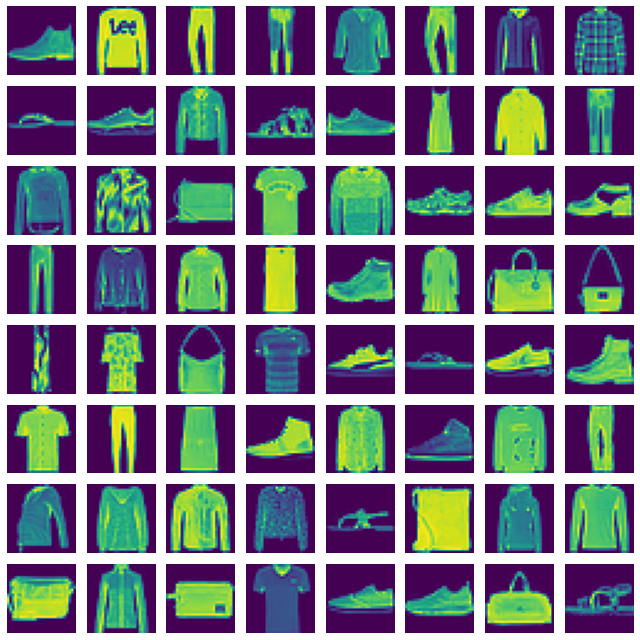

In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import scipy

plt.style.use('ggplot')

# Pytorch
import torch
import torchvision
from torchvision import datasets, transforms

# Project specifik modules
from utils import load_dataset, load_small_dataset, result_grid
from models import BetaVAE_fc
from solver import Solver


#We define the label names for alter if we want to know what kind of cloethes we are actually generating.
label_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 
               'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


train_set, val_set, test_set = load_dataset()
small_train = load_small_dataset(num_samples=10000)

# Loads one batch to plot it
batch_size = 128
_, (X_train, _) = next(enumerate(torch.utils.data.DataLoader(test_set, batch_size=batch_size)))

fig, axis = plt.subplots(8,8,figsize=(9, 9))
for ax, image in zip(axis.flatten(), X_train):
    ax.imshow(image.reshape(28, 28), aspect = 'auto', cmap = 'viridis')
    ax.axis('off')
    ax.grid(None)
plt.tight_layout()

### Specifing parameters for model and training

In [2]:
kwargs = {'learning_rate':5e-4,
          'batch_size' :   256,
          'lr_rate_decay': .5,
          'decay_every_': 2, 
          'weight_decay': 1e-4}

kl_weight = kwargs['batch_size']/len(train_set)

model = BetaVAE_fc(in_channels=1, latent_dim=3, beta= .01, kl_weight=kl_weight)

solver = Solver(model, train_set, val_set, test_set, **kwargs)
#small_solver = Solver(model, small_train, val_set, test_set, **kwargs)

### Training

In [3]:
#small_solver.overtrain_sample()
solver.train(30)

Validation: 100%|██████████| 47/47 [00:04<00:00, 11.63it/s, Epoch=30/30, KL_loss=42.9, Loss=0.317, MSE_loss=0.314]


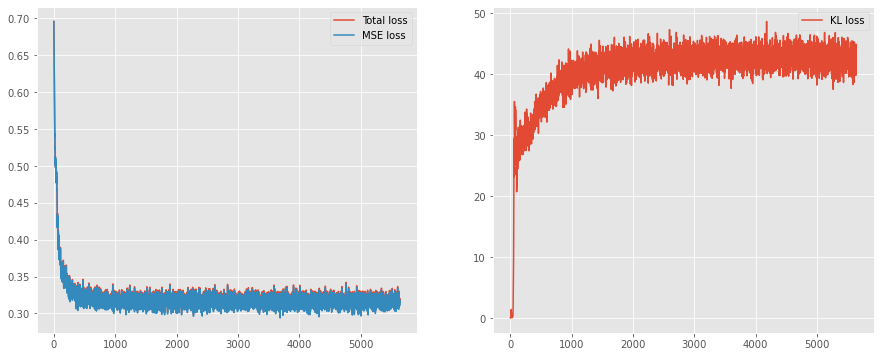

In [4]:
solver.plot_training_loss()

### Showing examples of reconstruction

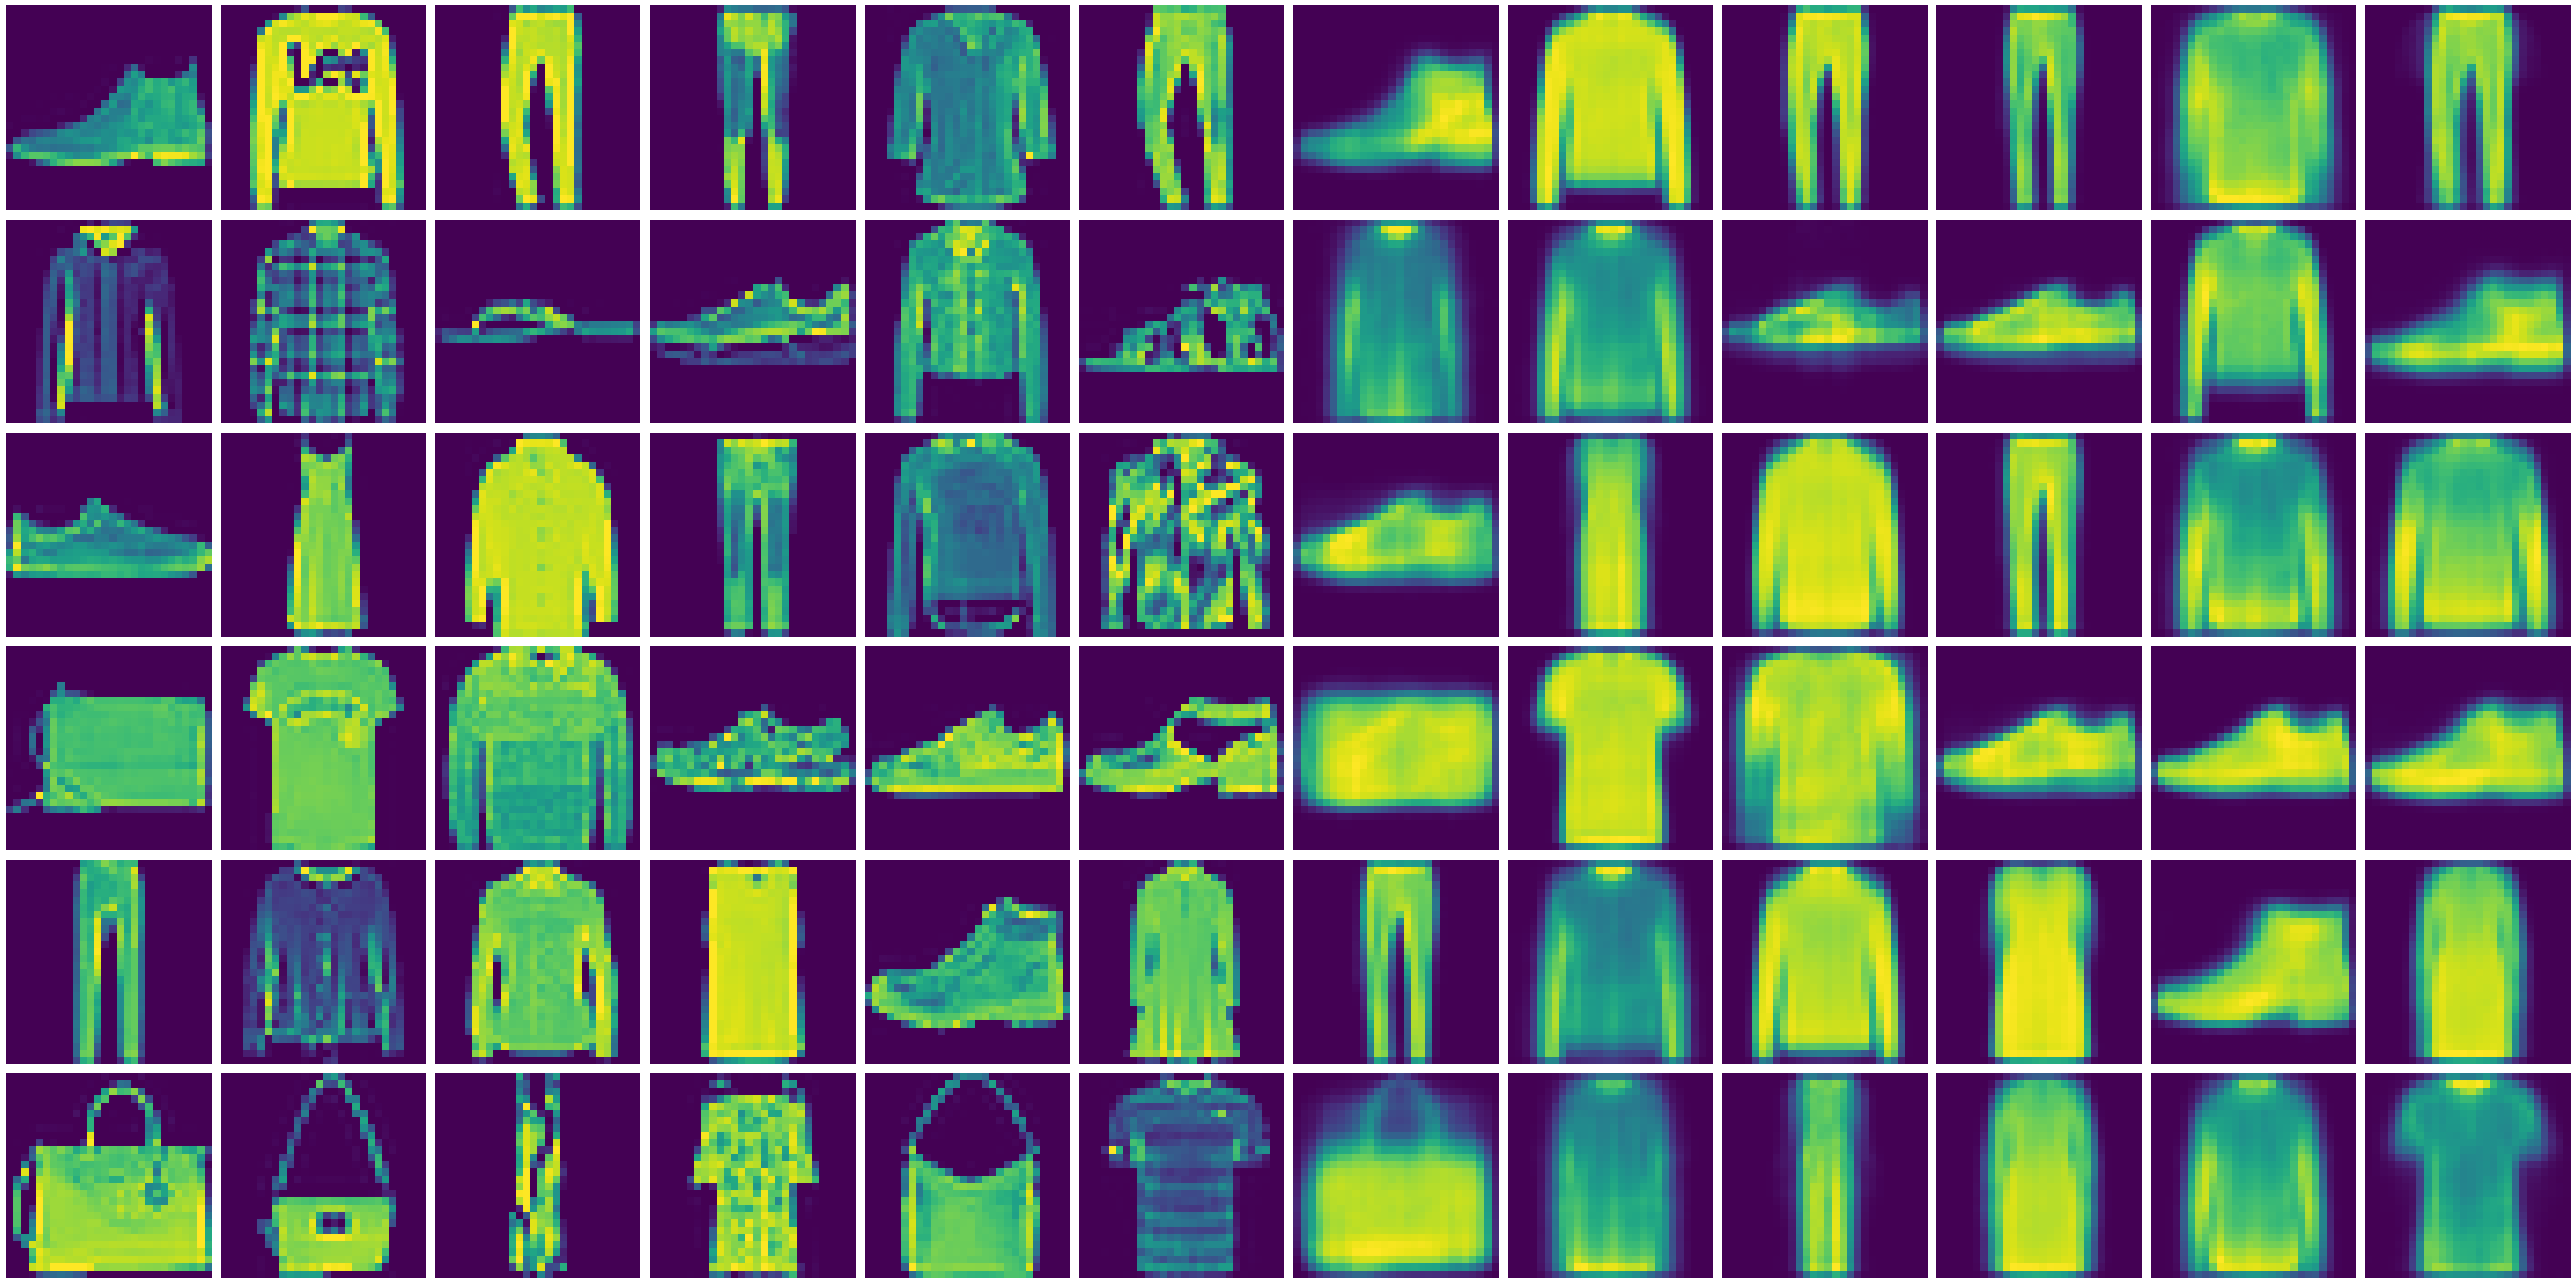

In [9]:
_, (X_test, _) = next(enumerate(torch.utils.data.DataLoader(test_set, batch_size=100)))
output, (_, _) = model.forward(X_test)

n_cols = 6
n_rows = 6

result_grid(n_cols, n_rows, X_test, output)

### Plotting how the different items of the test-set is divided in the latent space

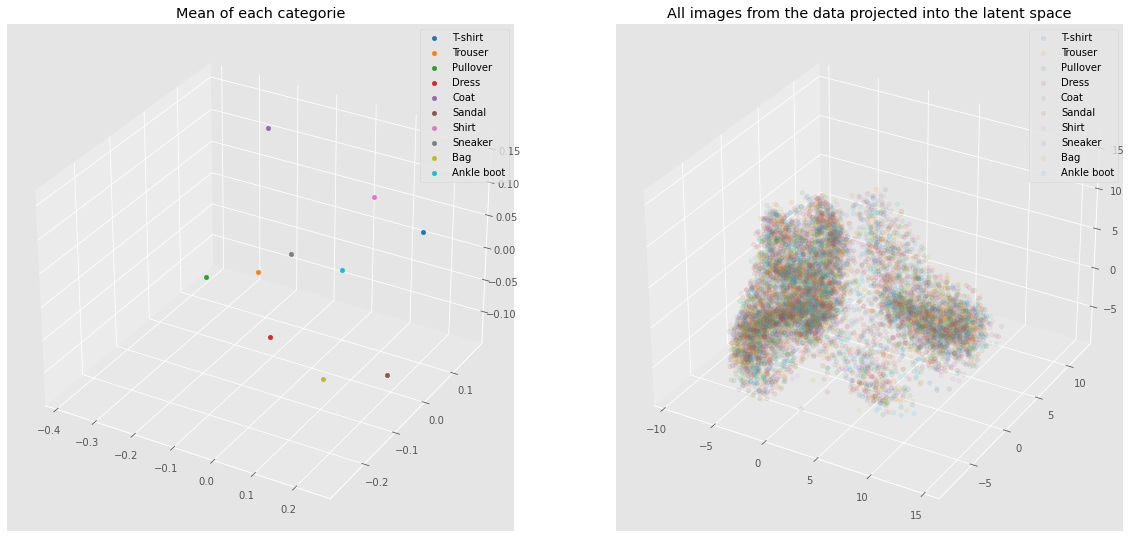

In [6]:
from sklearn.decomposition import PCA
# Projected down to a lower dim with PCA
predictions = PCA(3).fit_transform(solver.predict().detach().numpy())


label = test_set.targets

fig = plt.figure(figsize=(20, 10))
ax_1 = fig.add_subplot(121, projection='3d')
ax_2 = fig.add_subplot(122, projection='3d')


for i in torch.unique(label):
    mask = label == i
    tmp_data = predictions[mask]
    ax_1.scatter(tmp_data.mean(0)[0], tmp_data.mean(0)[1], tmp_data.mean(0)[2], label=label_names[i], c = list(mcolors.TABLEAU_COLORS)[i])
    ax_2.scatter(tmp_data[:, 0], tmp_data[:, 1], tmp_data[:, 2], label=label_names[i], c = list(mcolors.TABLEAU_COLORS)[i], alpha=0.1)
    ax_1.set_title('Mean of each categorie')
    ax_2.set_title('All images from the data projected into the latent space')
    
    
ax_1.legend()
ax_2.legend()


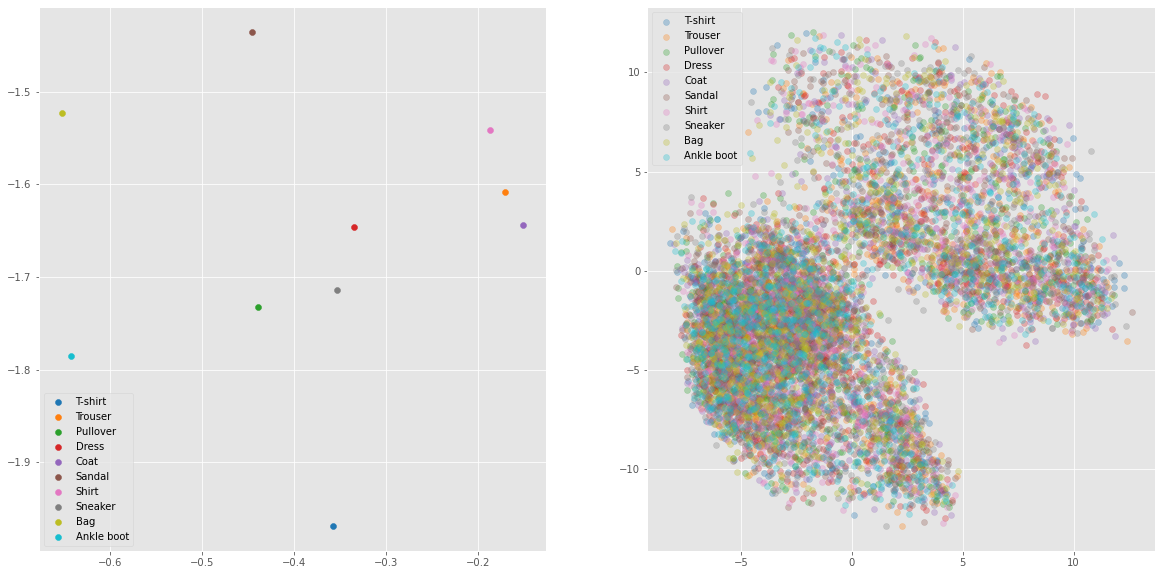

In [7]:
from sklearn.decomposition import PCA
# Projected down to a lower dim with PCA
predictions = solver.predict().detach().numpy()

label = test_set.targets

fig = plt.figure(figsize=(20, 10))
ax_1 = fig.add_subplot(121)
ax_2 = fig.add_subplot(122)


for i in torch.unique(label):
    mask = label == i
    tmp_data = predictions[mask]
    ax_1.scatter(tmp_data.mean(0)[0], tmp_data.mean(0)[1], label=label_names[i], c = list(mcolors.TABLEAU_COLORS)[i])
    ax_2.scatter(tmp_data[:, 0], tmp_data[:, 1], label=label_names[i], c = list(mcolors.TABLEAU_COLORS)[i], alpha=0.3)

ax_1.legend()
ax_2.legend()


## Generating new pieces of clothing

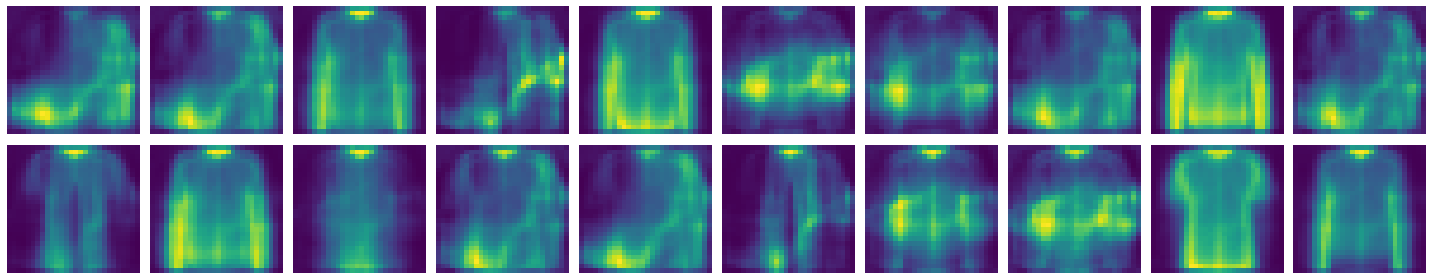

In [25]:
samples = model.sample(20)
fig, axis = plt.subplots(2, 10,figsize=(20, 4))
for ax, image in zip(axis.flatten(), samples):
    ax.imshow(image.detach().numpy().reshape(28, 28), aspect = 'auto', cmap = 'viridis')
    ax.axis('off')
    ax.grid(None)
plt.tight_layout()